In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

2.0.0


In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

True


# config

In [2]:
data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
img_height = 224#227
img_width = 224#227
batch_size = 4

# get dataset

In [3]:
def decode_str_tensor(tensor):
    return bytes.decode(tensor.numpy())

def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')

<tf.Tensor: id=67, shape=(), dtype=int64, numpy=0>

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    img = img/127.5 - 1
    return img, label
img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')
stats(img.numpy())

mean:-0.6299476 max:1.0 min:-1.0 median:-0.99215686 std:0.51195675 shape:(224, 224, 3) dtype:float32


In [6]:
def get_dataset(path):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache().shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = get_dataset(train_path)
test_ds = get_dataset(test_path)
val_ds = get_dataset(val_path)
train_ds

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (4, 224, 224, 3)
Label:  [1 1 0 1]


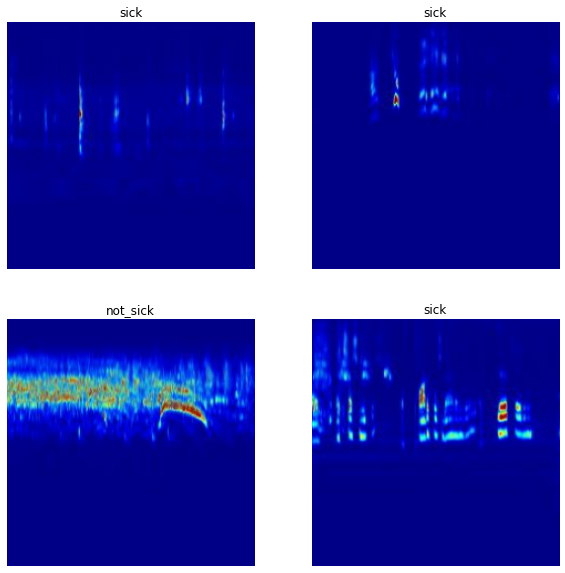

In [8]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(((image_batch[i].numpy() + 1)*127.5).astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model

### Feature extraction

IMG_SHAPE = (img_height, img_width, 3)
tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=IMG_SHAPE
)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
base_learning_rate = 0.0001
initial_epochs = 20

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
929/929 [==============================] - 19s 21ms/step - loss: 0.5856 - accuracy: 0.6529 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
929/929 [==============================] - 13s 14ms/step - loss: 0.5289 - accuracy: 0.7043 - val_loss: 0.5074 - val_accuracy: 0.7285
Epoch 3/20
929/929 [==============================] - 13s 14ms/step - loss: 0.5091 - accuracy: 0.7191 - val_loss: 0.4937 - val_accuracy: 0.7400
Epoch 4/20
929/929 [==============================] - 13s 14ms/step - loss: 0.4904 - accuracy: 0.7295 - val_loss: 0.4841 - val_accuracy: 0.7400
Epoch 5/20
929/929 [==============================] - 13s 14ms/step - loss: 0.4855 - accuracy: 0.7347 - val_loss: 0.4776 - val_accuracy: 0.7514
Epoch 6/20
929/929 [==============================] - 13s 14ms/step - loss: 0.4774 - accuracy: 0.7427 - val_loss: 0.4718 - val_accuracy: 0.7523
Epoch 7/20
929/929 [==============================] - 13s 14ms/step - loss: 0.4699 - accuracy: 0.7513 - val_loss: 0.4670 - val_a

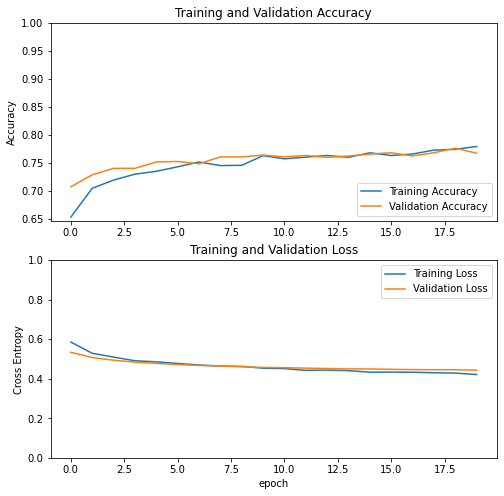

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
model.evaluate(test_ds)

413/413 [==============================] - 7s 17ms/step - loss: 0.4299 - accuracy: 0.7651


[0.42992439363647894, 0.76513314]

### fine tuning

In [14]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 55

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False

model.summary()

Number of layers in the base model:  155
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 35,393
Trainable params: 1,281
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
929/929 [==============================] - 50s 54ms/step - loss: 0.4507 - accuracy: 0.7659 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 21/30
929/929 [==============================] - 42s 46ms/step - loss: 0.3793 - accuracy: 0.8122 - val_loss: 0.4094 - val_accuracy: 0.8269
Epoch 22/30
929/929 [==============================] - 42s 45ms/step - loss: 0.3265 - accuracy: 0.8544 - val_loss: 0.3675 - val_accuracy: 0.8269
Epoch 23/30
929/929 [==============================] - 42s 45ms/step - loss: 0.2846 - accuracy: 0.8714 - val_loss: 0.3861 - val_accuracy: 0.8433
Epoch 24/30
929/929 [==============================] - 42s 45ms/step - loss: 0.2429 - accuracy: 0.8907 - val_loss: 0.4431 - val_accuracy: 0.8458
Epoch 25/30
929/929 [==============================] - 43s 46ms/step - loss: 0.2094 - accuracy: 0.9120 - val_loss: 0.3963 - val_accuracy: 0.8523
Epoch 26/30
929/929 [==============================] - 43s 46ms/step - loss: 0.1697 - accuracy: 0.9271 - val_loss: 0.4439 

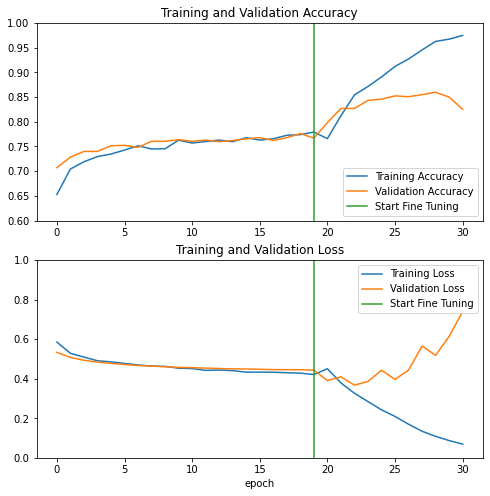

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
model.evaluate(test_ds)

413/413 [==============================] - 4s 10ms/step - loss: 0.7596 - accuracy: 0.8232


[0.759604990335627, 0.8232446]